MILESTONE - 1

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# 2. Load Dataset
df = pd.read_csv("/content/flights_sample_3m.csv")

In [11]:
print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (3000000, 32)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [12]:

# Convert FL_DATE to datetime
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")

# Extract date features
df["Year"] = df["FL_DATE"].dt.year
df["Month"] = df["FL_DATE"].dt.month
df["Day"] = df["FL_DATE"].dt.day
df["DayOfWeek"] = df["FL_DATE"].dt.dayofweek   # 0=Monday
df["IsWeekend"] = df["DayOfWeek"].isin([5,6]).astype(int)


In [13]:
# Convert HHMM -> Hours
def convert_to_hour(x):
    if pd.isnull(x): return np.nan
    x = int(x)
    return x // 100 + (x % 100) / 60.0

time_cols = ["CRS_DEP_TIME","DEP_TIME","CRS_ARR_TIME","ARR_TIME","WHEELS_OFF","WHEELS_ON"]
for col in time_cols:
    df[col+"_HOUR"] = df[col].apply(convert_to_hour)


In [14]:

# Merge delay reasons into one
delay_cols = ["DELAY_DUE_CARRIER","DELAY_DUE_WEATHER","DELAY_DUE_NAS","DELAY_DUE_SECURITY","DELAY_DUE_LATE_AIRCRAFT"]

df[delay_cols] = df[delay_cols].fillna(0)  # replace NaN with 0
df["PrimaryDelayReason"] = df[delay_cols].idxmax(axis=1)
df["PrimaryDelayMinutes"] = df[delay_cols].max(axis=1)

# Replace cases with no delay
df.loc[df["PrimaryDelayMinutes"] == 0, "PrimaryDelayReason"] = "NO_DELAY"


In [15]:
# Drop duplicates (if any)
df = df.drop_duplicates()

MILESTONE - 2

/tmp/ipython-input-1707176741.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Year", palette="viridis")


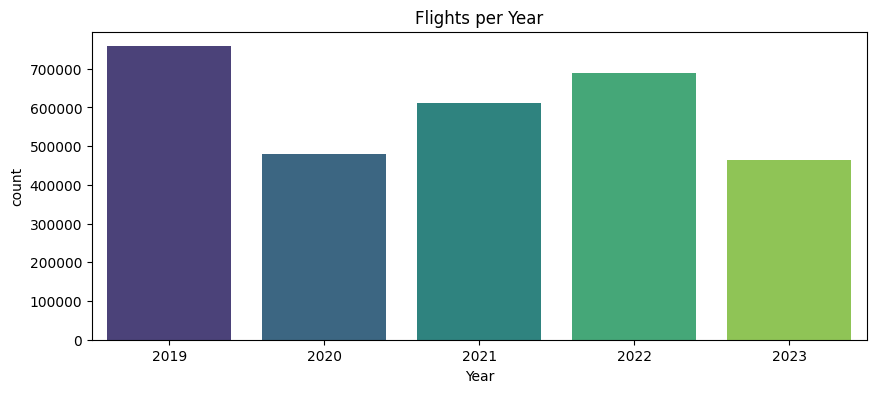

In [16]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="Year", palette="viridis")
plt.title("Flights per Year")
plt.show()

/tmp/ipython-input-3673904431.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Month", palette="coolwarm")


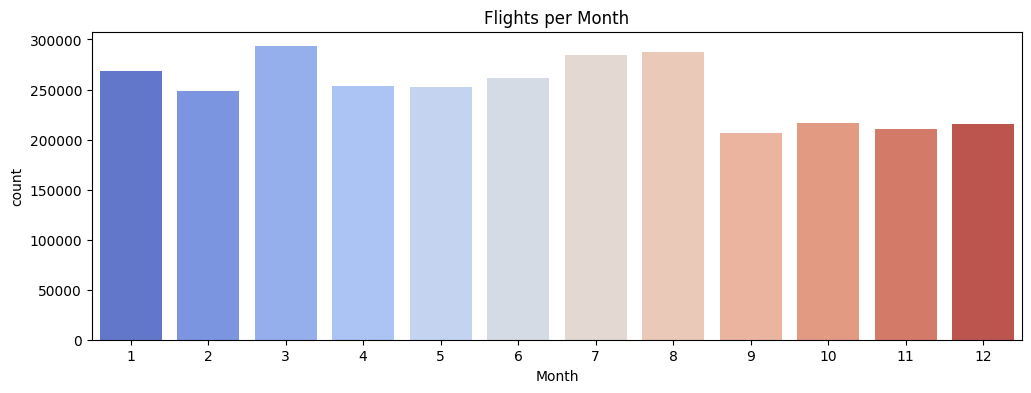

In [17]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="Month", palette="coolwarm")
plt.title("Flights per Month")
plt.show()

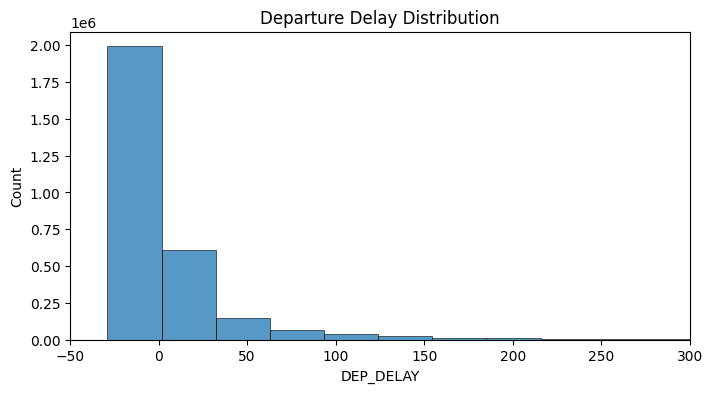

In [18]:
# Delay distribution
plt.figure(figsize=(8,4))
sns.histplot(df["DEP_DELAY"].dropna(), bins=100, kde=False)
plt.xlim(-50,300)
plt.title("Departure Delay Distribution")
plt.show()

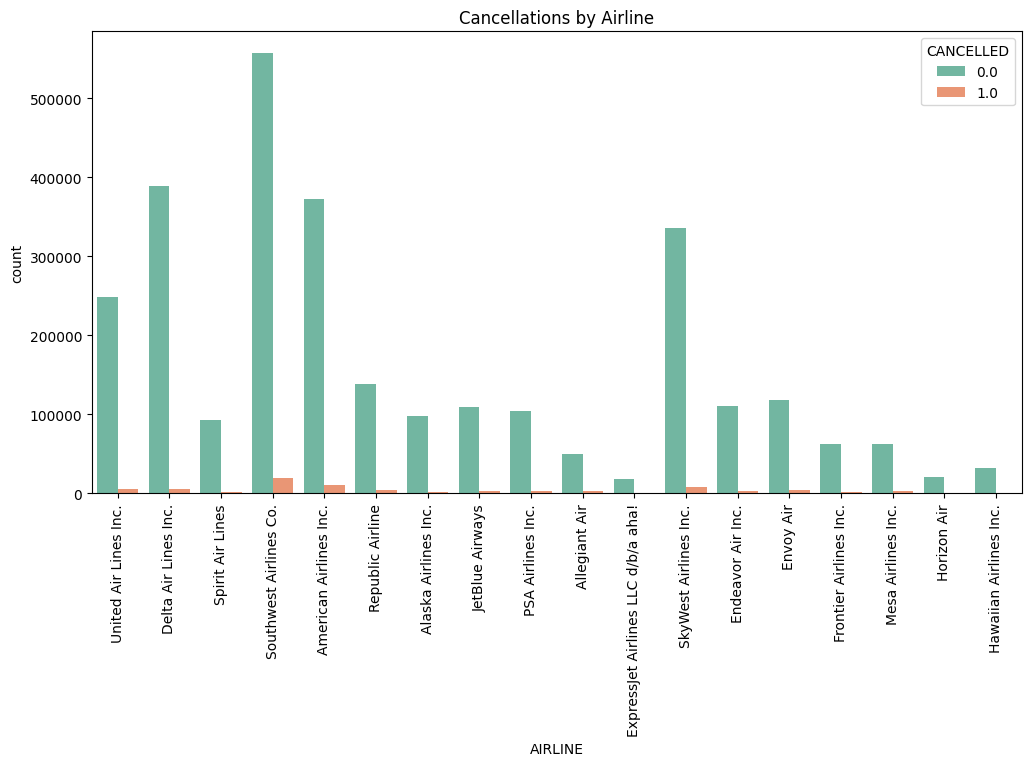

In [19]:
# Cancellations by Airline
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="AIRLINE", hue="CANCELLED", palette="Set2")
plt.title("Cancellations by Airline")
plt.xticks(rotation=90)
plt.show()

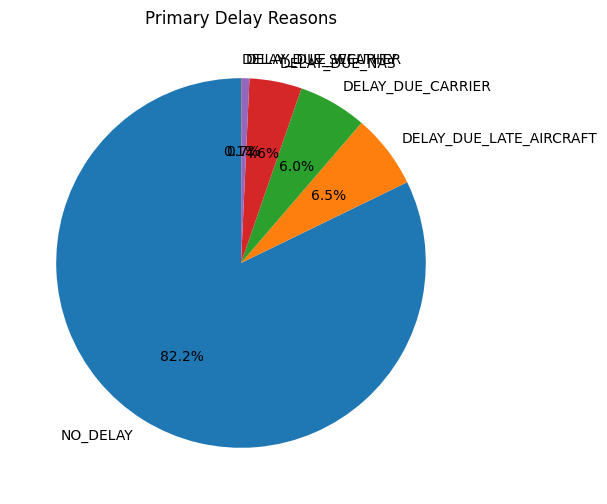

In [21]:
# Pie chart of delay reasons
reason_counts = df["PrimaryDelayReason"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(reason_counts, labels=reason_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Primary Delay Reasons")
plt.show()

/tmp/ipython-input-2921803921.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="DayOfWeek", y="DEP_DELAY", estimator=np.mean, palette="magma")


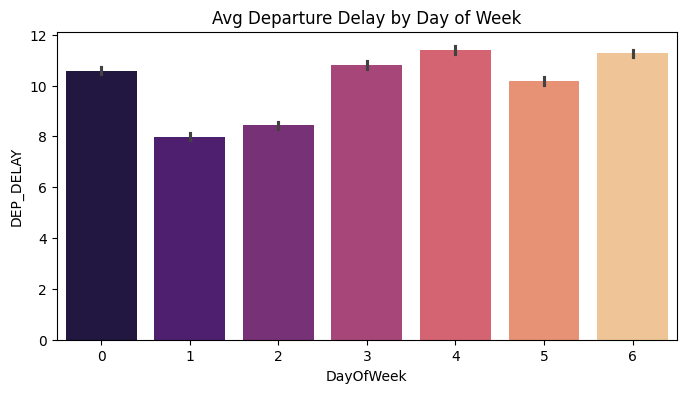

In [22]:
# Avg delay by day of week
plt.figure(figsize=(8,4))
sns.barplot(data=df, x="DayOfWeek", y="DEP_DELAY", estimator=np.mean, palette="magma")
plt.title("Avg Departure Delay by Day of Week")
plt.show()

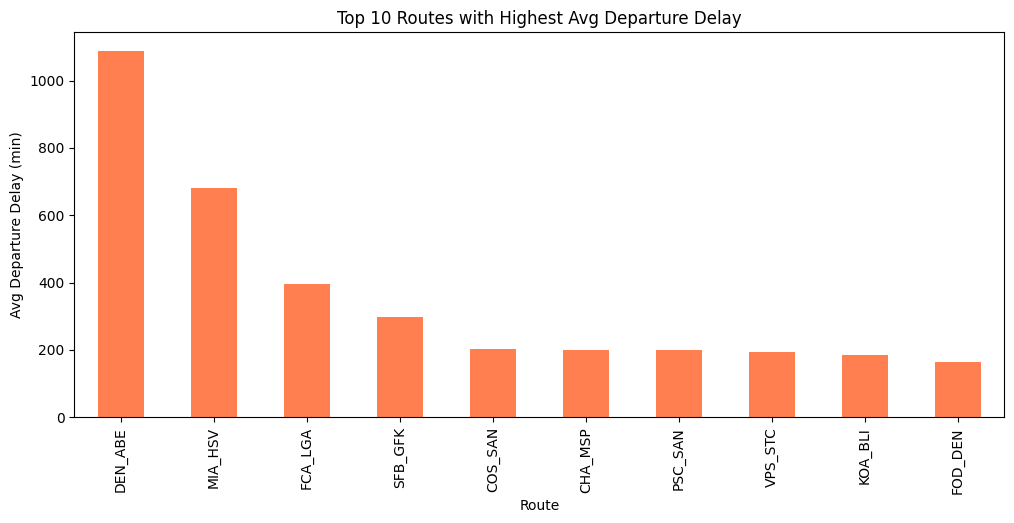

In [23]:
# Top 10 routes with highest avg delay
df["Route"] = df["ORIGIN"] + "_" + df["DEST"]
route_delays = df.groupby("Route")["DEP_DELAY"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,5))
route_delays.plot(kind="bar", color="coral")
plt.title("Top 10 Routes with Highest Avg Departure Delay")
plt.ylabel("Avg Departure Delay (min)")
plt.show()

In [24]:
# Missing values overview
missing = df.isnull().mean()*100
print("Missing Value Percentage:\n", missing[missing>0].sort_values(ascending=False).head(15))


Missing Value Percentage:
 CANCELLATION_CODE    97.362000
ARR_DELAY             2.873267
ELAPSED_TIME          2.873267
AIR_TIME              2.873267
WHEELS_ON_HOUR        2.664800
WHEELS_ON             2.664800
TAXI_IN               2.664800
ARR_TIME              2.664733
ARR_TIME_HOUR         2.664733
WHEELS_OFF_HOUR       2.626867
WHEELS_OFF            2.626867
TAXI_OUT              2.626867
DEP_DELAY             2.588133
DEP_TIME              2.587167
DEP_TIME_HOUR         2.587167
dtype: float64


In [25]:
# 💾 Save Cleaned Dataset
# -----------------------

df.to_csv("cleaned_flights.csv", index=False)
print("✅ Cleaned dataset saved as cleaned_flights.csv")

✅ Cleaned dataset saved as cleaned_flights.csv
